
# Capstone III: Quora Question Pairs

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

# 1. Data Wrangling and EDA

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

from fuzzywuzzy import fuzz

import spacy
nlp= spacy.load('en_core_web_md')

import distance

import wordcloud

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import jaccard_score

# from sentence_transformers import SentenceTransformer, util

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

from transformers import BertTokenizer, BertModel
import torch

import editdistance
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

## 1.1 Reading Data and Basic Stats

In [3]:
train= pd.read_csv(r"C:\Users\sina\Documents\train.csv")
display(train.head())
print(train.info())

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### 1.2.1 Distribution of Data Among DIfferent Output Classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

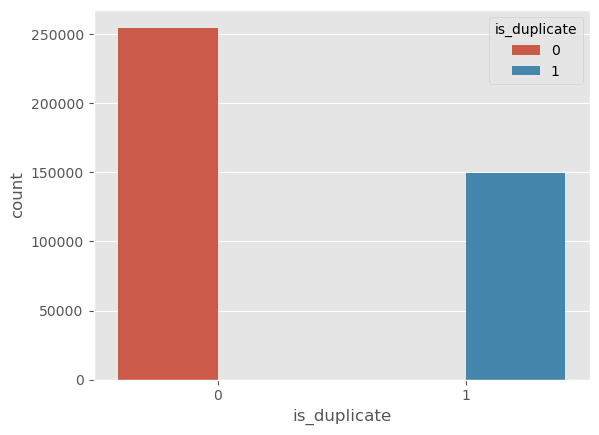

Total number of question pairs for training: 404290
Questions that are similar: 36.92%


In [4]:
sns.countplot(data=train, x='is_duplicate', hue= 'is_duplicate')
plt.show()

print(f'Total number of question pairs for training: {len(train)}\nQuestions that are similar: {100*train.is_duplicate.value_counts(normalize=True)[1]:.2f}%')

In [5]:
train.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

### 1.2.2 Number of Unique Questions

In [6]:
# All the questions
questions= pd.concat(objs=[train.question1, train.question2])
print(f"Total number of uniques questiona are: {len(set(questions))}")

# Number of repeated questions
print(f"Number of unique questions that appear more than once: {questions.duplicated(keep='first').sum()}, which is about {100*questions.duplicated().sum()/len(questions):.2f}% of the total questions")

# Max nuber of repetition
from collections import Counter

Counter(questions).most_common(1)

Total number of uniques questiona are: 537361
Number of unique questions that appear more than once: 271219, which is about 33.54% of the total questions


[('What are the best ways to lose weight?', 161)]

### 1.2.3 Checking for Dupplicates

In [7]:
#checking whether there are any repeated pair of questions

pair_duplicates= train.loc[train.question1 == train.question2]
print(len(pair_duplicates))

0


### 1.2.4 Number of occurrences of each question

,questions,numbers
0,What is the step by step guide to invest in sh...,1
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,4
2,How can I increase the speed of my internet co...,1
3,Why am I mentally very lonely? How can I solve...,1
4,"Which one dissolve in water quikly sugar, salt...",3


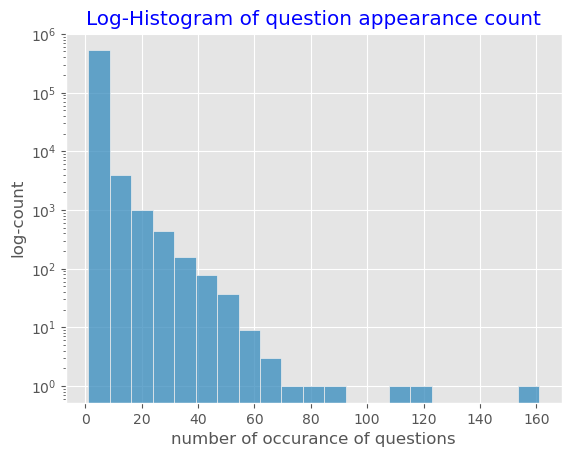

In [8]:
dict_counter= dict(Counter(questions))

questions_count_df= pd.DataFrame({'questions': dict_counter.keys(), 'numbers': dict_counter.values()})
display(questions_count_df.head())

sns.histplot(data= questions_count_df, x= 'numbers')
plt.yscale('log')
plt.xlabel('number of occurance of questions')
plt.ylabel('log-count')
plt.title('Log-Histogram of question appearance count', color= 'b')
plt.show()

### 1.2.5 Checking for Missing Values

In [9]:
# Check if there is missing values in a ny of the rows
print(train.isna().sum(), '\n')

# Show the rows with missing values
display(train.loc[train.isna().any(axis=1)])

# Fill the  missing values with ''
train.fillna('', inplace= True)

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64 



,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [10]:
from spacy.tokens import Doc, Span

In [11]:
import spacy

nlp= spacy.load('en_core_web_sm')

def qlen(doc):
    return len(doc)

Doc.set_extension('question_length', method= qlen, force= True)
doc= nlp('How can I develop android app?')
print(doc._.question_length())

7


## 1.3 Basic Feature Extraction (Before Cleaning)

Let us now construct a few features like:

____freq_qid1____ = Frequency of qid1's in the 'question1' column

____freq_qid2____ = Frequency of qid2's in the 'question2' column

____freq_qid1_total____ = Frequency of qid1's in all questions combined

____freq_qid2_total____ = Frequency of qid2's in all questions combined

____q1len____ = Length of q1

____q2len____ = Length of q2

____q1_n_words____ = Number of words in Question 1

____q2_n_words____ = Number of words in Question 2

____word_Common____ = (Number of common unique words in Question 1 and Question 2)

____word_Total____ = UNIQUE (Total num of words in Question 1 + Total num of words in Question 2)

____word_share____ = (word_common)/(word_Total)

____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2

____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [12]:
display(questions_count_df.head())
print(dict_counter['How can I develop android app?'])

,questions,numbers
0,What is the step by step guide to invest in sh...,1
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,4
2,How can I increase the speed of my internet co...,1
3,Why am I mentally very lonely? How can I solve...,1
4,"Which one dissolve in water quikly sugar, salt...",3


2


In [13]:
train['freq_qid1']= train.groupby('question1')['question1'].transform('size')
train['freq_qid2']= train.groupby('question2')['question2'].transform('size')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1


In [14]:
count_list=[]
for row_tuple in train.itertuples():
    try:
        count_list.append(dict_counter[row_tuple.question1])
    except:
        count_list.append(0)

train['freq_qid1_total']= count_list


count_list=[]
for row_tuple in train.itertuples():
    try:
        count_list.append(dict_counter[row_tuple.question2])
    except:
        count_list.append(0)
        
train['freq_qid2_total']= count_list

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1


In [15]:
train['q1len']= train.question1.str.len()
train['q2len']= train.question2.str.len()

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1,73,59


In [16]:
train['q1_n_words']= train.question1.apply(lambda x: len(x.split()))
train['q2_n_words']= train.question2.apply(lambda x: len(x.split()))

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,4,2,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10


In [17]:
def word_common(df, col1, col2):
    df[col1]=df[col1].str.lower()
    df[col2]= df[col2].str.lower()

    return df.apply(lambda x: len(set.intersection(set(x[col1].split()), set(x[col2].split()))), axis=1)

train['word_Common']= word_common(train, 'question1', 'question2')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10,4


In [18]:
def unique_word_total(df, col1, col2):
    return df.apply(lambda x: len(set(x[col1].split())) + len(set(x[col2].split())), axis=1)

train['word_Total']= unique_word_total(train, 'question1', 'question2')

train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10,23
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4,20
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,1,1,73,59,14,10,4,24


In [19]:
train['word_share']= train['word_Common']/train['word_Total']

In [20]:
train['freq_q1+freq_q2']= train['freq_qid1'] + train['freq_qid2']

In [21]:
train['freq_q1-freq_q2']= (train['freq_qid1'] - train['freq_qid2']).abs()

In [22]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,51,88,8,13,4,20,0.200000,5,3


### 1.3.1 Analysis of some of the extracted features

In [23]:
print('Minimum length of the question in question1 is:', train['q1_n_words'].min(), '\n')
print('Minimum length of the question in question2 is:', train['q2_n_words'].min(), '\n')

print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Minimum length of the question in question1 is: 0 

Minimum length of the question in question2 is: 0 

Number of Questions with minimum length [question1] : 69
Number of Questions with minimum length [question2] : 25


#### 1.3.1.1 Feature: word_share

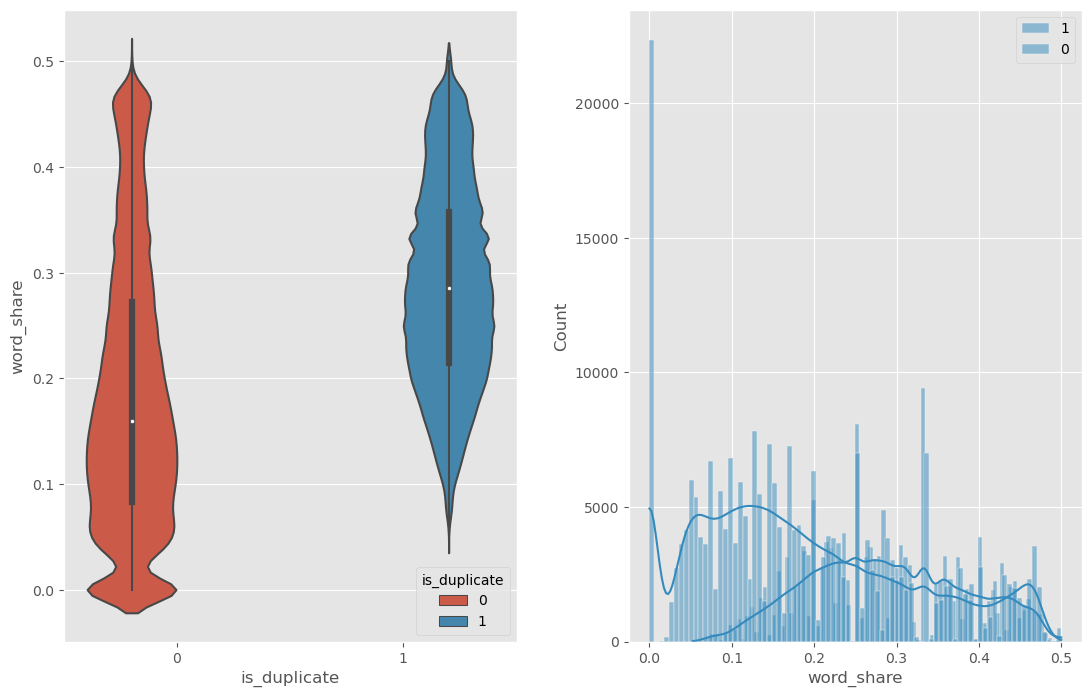

In [24]:
fig, ax= plt.subplots(1,2, figsize= (12, 8))

fig.tight_layout(pad=5.0)

plt.subplot(1,2,1)
sns.violinplot(data= train, x= 'is_duplicate', y= 'word_share', hue='is_duplicate', ax=ax[0])

plt.subplot(1,2,2)
sns.histplot(data=train.loc[train['is_duplicate']==1], x='word_share', label= '1', kde= True, ax=ax[1])
sns.histplot(data=train.loc[train['is_duplicate']==0], x='word_share', label= '0', kde= True, ax=ax[1])
ax[1].legend()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### 1.3.1.2 Feature: word_common

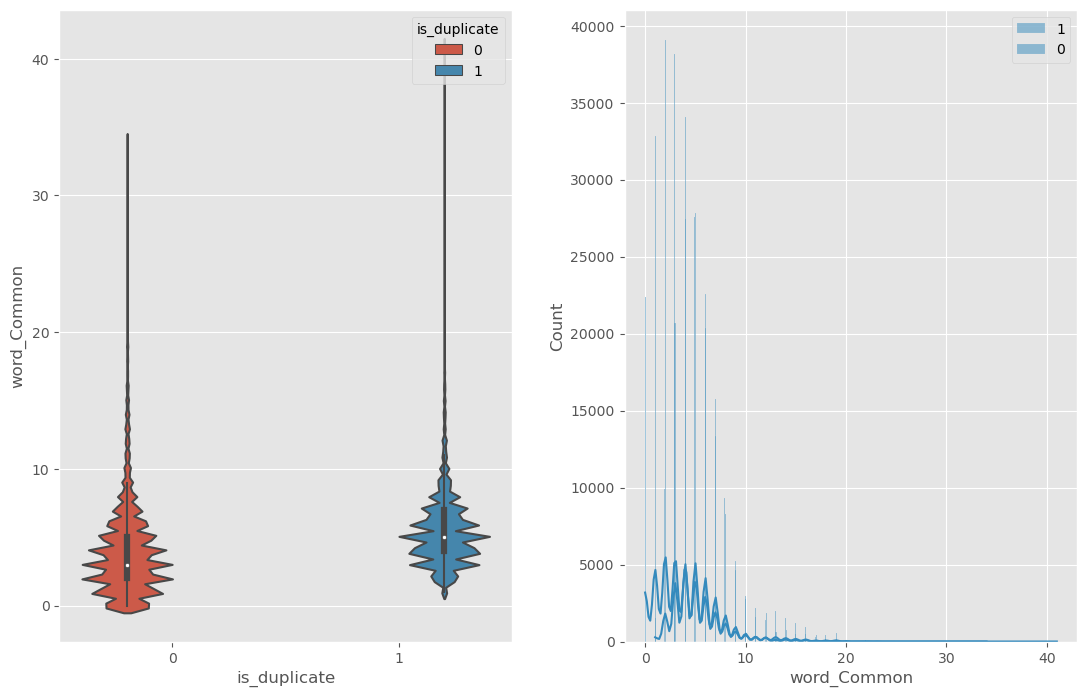

In [25]:
fig, ax= plt.subplots(1,2, figsize= (12, 8))

fig.tight_layout(pad=5.0)

plt.subplot(1,2,1)
sns.violinplot(data= train, x= 'is_duplicate', y= 'word_Common', hue= 'is_duplicate', ax=ax[0])

plt.subplot(1,2,2)
sns.histplot(data=train.loc[train['is_duplicate']==1], x='word_Common', label= '1', kde= True, ax=ax[1])
sns.histplot(data=train.loc[train['is_duplicate']==0], x='word_Common', label= '0', kde= True, ax=ax[1])
ax[1].legend()

## 1.4 Preprocessing of Text

* **Preprocessing:**
    - Lowercasing
    - Lemmatization
    - Manual replacement

In [26]:
# Write a preprocessing function

def preprocess(x):
    # Lowercasing
    x= x.lower()
    # Manual Replacement
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x= re.sub(pattern='(\d+)000000', repl='\1m', string=x)
    x= re.sub(pattern='(\d+)000', repl= '\1k', string=x)
    # Lemmatization
    x=' '.join([token.lemma_ for token in nlp(x)])
    
    return x

In [35]:
train['question1_pp']= train.question1.apply(preprocess)

In [36]:
train['question2_pp']= train.question2.apply(preprocess)

from nltk.stem import PorterStemmer\
from bs4 import BeautifulSoup

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

train['question1_pp2']= train.question1.apply(preprocess)

## 1.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

Token: You get a token by splitting sentence a space\
Stop_Word : stop words as per NLTK.\
Word : A token that is not a stop_word\
Features:

- __cwc_min__ : Ratio of common_word_count to min lenghth of word count of Q1 and Q2\
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- __cwc_max__ : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

- __csc_min__ : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

- __csc_max__ : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- __ctc_min__ : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

- __ctc_max__ : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


- __last_word_eq__ : Check if Last word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


- __first_word_eq__ : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])


- __abs_len_diff__ : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


- __mean_len__ : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2


- __fuzz_ratio__ 

- __fuzz_partial_ratio__ 

- __token_sort_ratio__ 

- __token_set_ratio__ 

- __longest_substr_ratio__ : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens)

### TFIDF and Cosine Similarity: This Cosine similarity is different as it is based on the tfidf vectors
**There are two ways of doing it:**
- 1) Concatenate question1 and question2 in each row and find the tfidf and cosine similarities for the combined column
- 2) Find the tfidf and cosine similarity for each row separately

TF-IDF (Term Frequency-Inverse Document Frequency) similarity is a metric used to quantify the similarity between two documents or pieces of text based on the words they contain. TF-IDF takes into account the frequency of terms (words) in a document relative to their frequency across a collection of documents. It is commonly used in information retrieval and text mining.

Here's how TF-IDF similarity is calculated:

**1) Term Frequency (TF):**
Term Frequency measures how often a term (word) appears in a document. It is calculated as the ratio of the number of times a term occurs in a document to the total number of terms in the document. The idea is to give higher weight to terms that appear more frequently in the document.


**2) Inverse Document Frequency (IDF):**
Inverse Document Frequency measures the importance of a term in the entire collection of documents. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. The idea is to give higher weight to terms that are less common across all documents.
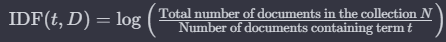

**3) TF-IDF Score:**
The TF-IDF score for a term in a document is the product of its Term Frequency and Inverse Document Frequency.


**4) TF-IDF Similarity:**
TF-IDF Similarity between two documents (or pieces of text) is calculated as the cosine similarity between their TF-IDF vectors. The TF-IDF vectors represent the documents in a high-dimensional space, where each dimension corresponds to a unique term.
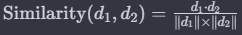
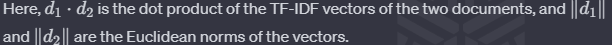

### Levenshtein Distance
Levenshtein distance, also known as edit distance, is a measure of the similarity between two strings by calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into the other. In the context of Levenshtein distance or similar string similarity metrics, lower values indeed indicate greater similarity.

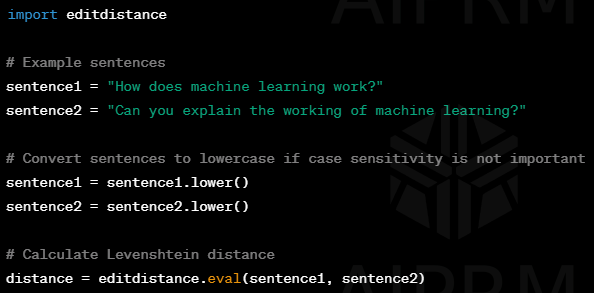

### Jaccard Similarity:
Jaccard Similarity is a measure of similarity between two sets. It's defined as the size of the intersection of the sets divided by the size of the union of the sets. The Jaccard Similarity is often used in the context of comparing the similarity between two sets of elements, such as words, tokens, or documents.
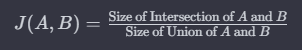
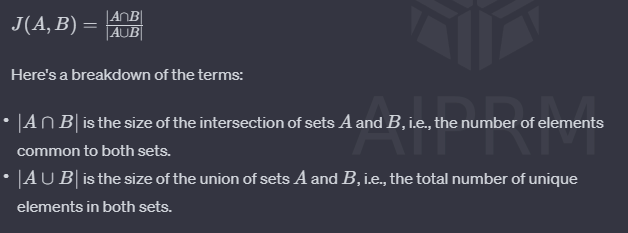

The Jaccard Similarity ranges from 0 to 1, where 0 means no similarity (no common elements) and 1 means complete similarity (all elements are the same). It provides a way to quantify the similarity between sets irrespective of the order or frequency of elements.

Jaccard Similarity is commonly used in various applications, including text mining, information retrieval, and recommendation systems, where measuring the similarity between sets of items is important.

**With the other features, there is no need to compute the Jaccard similarity here**

In [57]:
vectorizer= TfidfVectorizer(lowercase= True)


Levenshtein distance, also known as edit distance, is a measure of the similarity between two strings by calculating the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into the other.

In [82]:
def get_features(q1, q2):
    
    features=[]
    
    # Converting sentences (rows) into tokens
    q1_tokens= word_tokenize(q1)
    q2_tokens= word_tokenize(q2)
    
    # Remove the stop words from the tokens and create the unique words
    q1_words= set([word for word in q1_tokens if word not in stopwords.words('english')])
    q2_words= set([word for word in q2_tokens if word not in stopwords.words('english')])
    
    # Get the stop wprds in questions
    q1_stops= set([word for word in q1_tokens if word in stopwords.words('english')])
    q2_stops= set([word for word in q2_tokens if word in stopwords.words('english')]) 
    
    # Get the # common non-stop words from question pair
    common_word_count= len(set.intersection(q1_words, q2_words))
    
    # Get the common stop wprds from question pair
    common_stop_count= len(set.intersection(q1_stops, q2_stops))
     
    # Get the comon tokens from question pair
    common_token_count= len(set.intersection(set(q1_tokens), set(q2_tokens)))
    
    ####
    
    # In order to not divide the numbers by ZERO we add a saf_div variable to the denominators
    safe_div = 0.0001 
    
    # Ratio of common_word_count to min lenghth of word count of Q1 and Q2
    features.append(round(common_word_count/(min(len(q1_words), len(q2_words))+safe_div), 6))
    # Ratio of common_word_count to max lenghth of word count of Q1 and Q2
    features.append(round(common_word_count/(max(len(q1_words), len(q2_words))+safe_div), 6))
    
    # Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
    features.append(round(common_stop_count/(min(len(q1_stops), len(q2_stops))+safe_div), 6))
    # Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    features.append(round(common_stop_count/(max(len(q1_stops), len(q2_stops))+safe_div), 6))
    
    # Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    features.append(round(common_token_count/(min(len(q1_tokens), len(q2_tokens))+safe_div), 6))
    features.append(round(common_token_count/(max(len(q1_tokens), len(q2_tokens))+safe_div), 6))

   ####

    try:
        # Check if Last word of both questions is equal or not
        features.append(int(q1_tokens[-1]==q2_tokens[-1]))
    
        # Check if First word of both questions is equal or not
        features.append(int(q1_tokens[0]==q2_tokens[0]))
    except:
        features.append(int(False))
        features.append(int(False))
    
    ####
    
    # Absolute length difference
    features.append(abs(len(q1_tokens)-len(q2_tokens)))
    # Average token length of both questions
    features.append(np.mean(len(q1_tokens)+len(q2_tokens)))
    
    #### SIMILARITIES
    
    # 1: Find the similarity: Cosaine similarity
    features.append(nlp(q1).similarity(nlp(q2)))
    
    # 2: Separate TF-IDF matrices for each pair
    features.append(cosine_similarity(vectorizer.fit_transform([q1, q2]))[0][1])
    
    # 3: Levenshtein Distance
    features.append(editdistance.eval(q1, q2))
    
    # 4: Jaccard Similarity
    #features.append(jaccard_score(list(set1), list(set2)))
    
    # Fuzzy partial ratio
    features.append(fuzz.partial_ratio(q1, q2))
    # Token sort ratio
    features.append(fuzz.token_sort_ratio(q1, q2))
    # token set ratio
    features.append(fuzz.token_set_ratio(q1, q2))
    
    return features

In [95]:
features= train.apply(lambda x: get_features(x['question1_pp'], x['question2_pp']), axis=1)

C:\Users\sina\AppData\Local\Temp\ipykernel_41348\2578339170.py:67: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  features.append(nlp(q1).similarity(nlp(q2)))


In [96]:
x=[]
for i in range(len(features[0])):
    x.append(features.apply(lambda x: x[i]))

In [97]:
features_df= pd.DataFrame({'cwc_min': x[0], 'cwc_max': x[1], 'csc_min': x[2], 'csc_max': x[3], 'ctc_min': x[4], 
                           'ctc_max': x[5], 'last_word_eq': x[6], 'first_word_eq': x[7], 'abs_len_diff': x[8],
                           'mean_len': x[9], 'cos_sim': x[10], 'cos_sim_tfidf': x[11], 'Levenshtein_dist': x[12],
                           'fuzzy_partial_ratio': x[13], 'token_sort_ratio': x[13], 'token_set_ratio': x[14]})

In [98]:
train= pd.concat([train, features_df], axis=1)

### Other Features

#### Find the longest substring

In [100]:
docs1= list(nlp.pipe(train.question1_pp))
docs2= list(nlp.pipe(train.question2_pp))

In [101]:
safe_div = 0.0001 

min_len= lambda x, y: min(len(x), len(y))
min_token_len= [min_len(x, y)+safe_div for x, y in zip(docs1, docs2)]

In [102]:
lssr= []
for idx, row in train.iterrows():
    lssr.append(list(distance.lcsubstrings(row['question1_pp'], row['question2_pp'])))

In [103]:
train['longest_substr_ratio']= [len(lssr[i][0].split())/min_token_len[i] if len(lssr[i])!=0 else 0 for i in range(len(lssr))]

### Bert Embedding:

BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained natural language processing (NLP) model developed by Google. BERT embeddings refer to the vector representations of words or sentences generated by the BERT model. These embeddings capture rich semantic information about the input text and are often used for various NLP tasks, including calculating the similarity between two sentences.

To use BERT embeddings for sentence similarity, you can follow these general steps:

Tokenization: Break down each sentence into its constituent words or subwords. BERT uses WordPiece tokenization, which may break down words into smaller subword units.

Padding and Truncation: Ensure that the input sequences have a consistent length. You may need to pad shorter sequences or truncate longer ones to fit the model's input size.

Conversion to Embeddings: Feed the tokenized and processed sentences into the BERT model, and obtain the embeddings for each token. In the case of sentence similarity, you often use the embedding of the [CLS] (classification) token, which is typically located at the beginning of the output sequence.

Similarity Calculation: Use a similarity metric (e.g., cosine similarity) to measure the similarity between the obtained embeddings of the two sentences.

Here's a simplified example using the transformers library in Python, which provides an easy interface to use pre-trained BERT models:

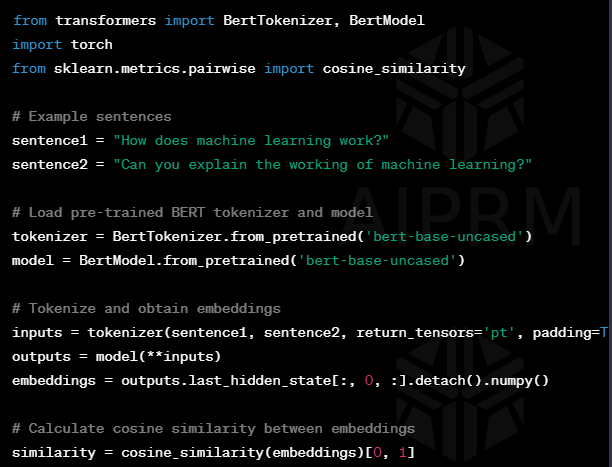


The BertTokenizer is used to tokenize the sentences.
The BertModel is loaded to obtain the embeddings.
The [CLS] token embedding is extracted and used for calculating the cosine similarity between the two sentences.

In [ ]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [10]:
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for two columns in a row
def get_bert_embeddings(row):
    # Concatenate the text from two columns
    text = f"{row['question1_pp']} {row['question2_pp']}"

    # Tokenize input text
    tokens = tokenizer(text, return_tensors='pt')

    # Forward pass through BERT model
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract embeddings from the output
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Apply BERT embeddings to each row
train['bert_embeddings'] = train.apply(get_bert_embeddings, axis=1)

In [21]:
cosine_similarity(train['bert_embeddings'][:1000].tolist()).diagonal()

array([1.0000004 , 0.99999964, 0.9999999 , 1.0000001 , 0.99999994,
       0.9999997 , 1.        , 1.0000002 , 1.        , 0.9999999 ,
       0.9999999 , 1.0000002 , 1.0000001 , 0.9999999 , 1.0000002 ,
       1.0000001 , 0.99999994, 0.9999999 , 1.        , 1.0000001 ,
       1.        , 1.0000005 , 0.99999994, 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 0.99999976, 0.99999994,
       1.        , 1.0000001 , 1.0000001 , 0.9999999 , 1.0000001 ,
       1.        , 1.0000002 , 1.0000002 , 1.0000001 , 1.0000002 ,
       1.        , 1.        , 0.99999994, 0.99999994, 0.9999998 ,
       1.        , 0.9999999 , 0.9999999 , 1.0000002 , 1.0000001 ,
       0.9999999 , 1.0000001 , 1.0000001 , 1.0000001 , 0.9999999 ,
       1.0000001 , 1.        , 1.0000001 , 1.0000002 , 0.9999997 ,
       0.99999976, 0.9999997 , 1.0000002 , 1.0000002 , 1.0000001 ,
       1.        , 1.0000001 , 0.99999964, 1.        , 0.9999999 ,
       1.0000002 , 0.9999998 , 0.9999997 , 0.99999964, 0.99999

**<span style= "color: red"> Cosine similarity with Bert embedding is not providing any valuable info</span>**

### Word Embedding

In [106]:
def process_text(text):
    return nlp(text)

word_embedding_similarity= []

for i in range(len(docs1)):
    word_embedding_similarity.append(cosine_similarity(docs1[i].vector.reshape(-1,1), docs2[i].vector.reshape(-1,1))[0][0])

In [108]:
train['word_embedding_similarity']= word_embedding_similarity

In [15]:
train.to_csv('train.csv', index= None)

## <span style="color:green">The data is saved in a csv file, import the saved data and continue working on that

## 1.6 Analysis of extracted features

### 1.6.1 Create word clouds

In [3]:
# Import the preprocessed data:
train= pd.read_csv('train.csv')

In [22]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,freq_qid1_total,freq_qid2_total,...,mean_len,cos_sim,cos_sim_tfidf,Levenshtein_dist,fuzzy_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio,word_embedding_similarity,bert_embeddings
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,1,1,...,28,0.980570,0.920307,9,98,98,93,0.923070,1,"[0.00016680956, -0.37813663, 0.00556882, -0.17..."
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,4,2,...,35,0.814954,0.424251,43,78,78,62,0.599996,1,"[0.14002122, -0.15146321, -0.13891713, -0.1873..."


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         404290 non-null  int64  
 1   qid1                       404290 non-null  int64  
 2   qid2                       404290 non-null  int64  
 3   question1                  404289 non-null  object 
 4   question2                  404288 non-null  object 
 5   is_duplicate               404290 non-null  int64  
 6   freq_qid1                  404290 non-null  int64  
 7   freq_qid2                  404290 non-null  int64  
 8   freq_qid1_total            404290 non-null  int64  
 9   freq_qid2_total            404290 non-null  int64  
 10  q1len                      404290 non-null  int64  
 11  q2len                      404290 non-null  int64  
 12  q1_n_words                 404290 non-null  int64  
 13  q2_n_words                 40

In [24]:
dup= train.loc[train.is_duplicate==1]
non_dup= train.loc[train.is_duplicate==0]

**Dubpicated & Non-duplicated corpus**

In [25]:
from spacy.lang.en import STOP_WORDS

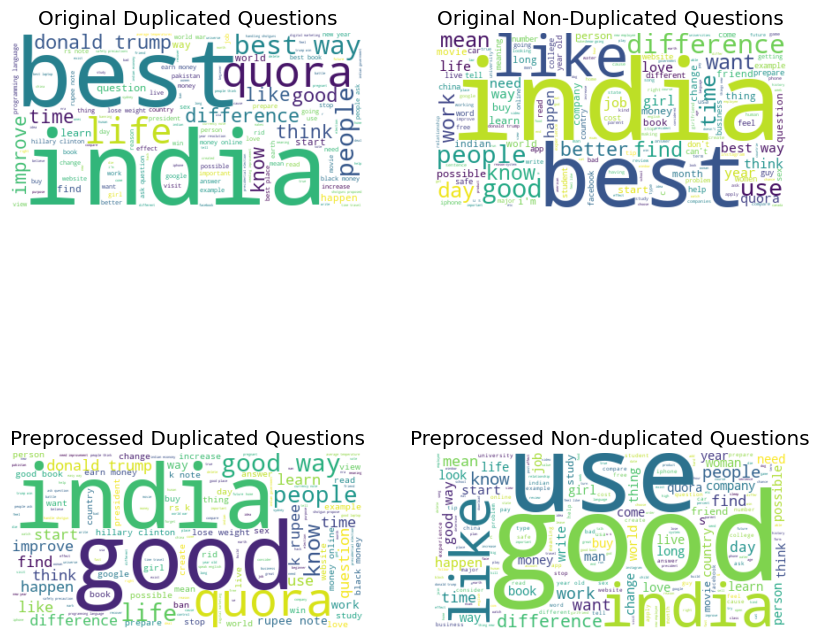

In [26]:
fig, ax= plt.subplots(2,2, figsize=(10, 10))

dup_corp= dup['question1'].str.cat(sep=' ')+' '+dup['question2'].str.cat(sep= ' ')
non_dup_corp= non_dup['question1'].str.cat(sep=' ')+' '+non_dup['question2'].str.cat(sep= ' ')

wc= wordcloud.WordCloud(background_color='white', stopwords= STOP_WORDS)
wc.generate(dup_corp)
ax[0,0].imshow(wc, interpolation= 'bilinear')
ax[0,0].axis('off')
ax[0,0].set_title('Original Duplicated Questions')

wc.generate(non_dup_corp)
ax[0,1].imshow(wc, interpolation= 'bilinear')
ax[0,1].axis('off')
ax[0,1].set_title('Original Non-Duplicated Questions')

dup_corp= dup['question1_pp'].str.cat(sep=' ')+' '+dup['question2_pp'].str.cat(sep= ' ')
non_dup_corp= non_dup['question1_pp'].str.cat(sep=' ')+' '+non_dup['question2_pp'].str.cat(sep= ' ')

wc= wordcloud.WordCloud(background_color='white', stopwords= STOP_WORDS)
wc.generate(dup_corp)
ax[1,0].imshow(wc, interpolation= 'bilinear')
ax[1,0].axis('off')
ax[1,0].set_title('Preprocessed Duplicated Questions')

wc.generate(non_dup_corp)
ax[1,1].imshow(wc, interpolation= 'bilinear')
ax[1,1].axis('off')
ax[1,1].set_title('Preprocessed Non-duplicated Questions')
plt.show()

### 1.6.2 Pairplots

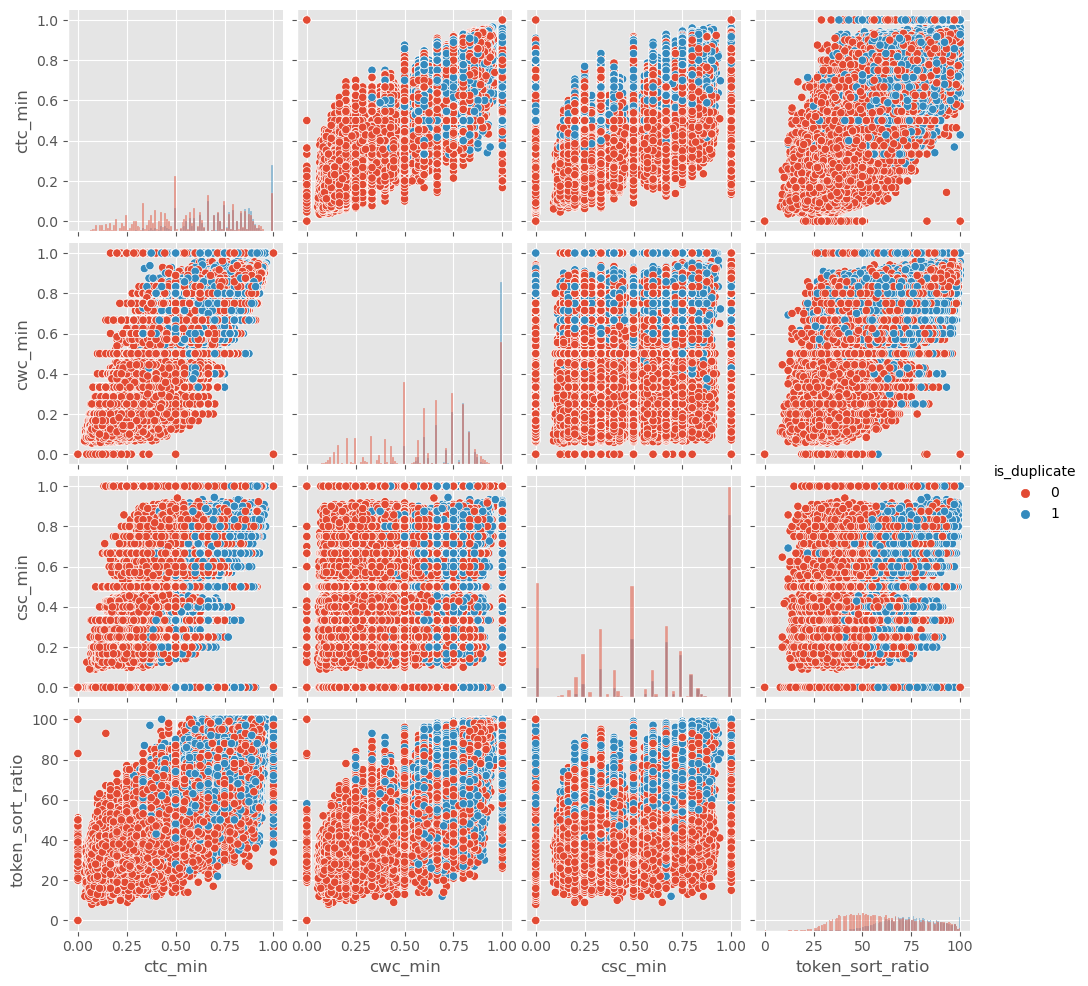

In [27]:
sns.pairplot(data=train, vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'], hue= 'is_duplicate', diag_kind='hist')
plt.show()

In [28]:
print(train.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'freq_qid1_total', 'freq_qid2_total', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+freq_q2', 'freq_q1-freq_q2', 'question1_pp',
       'question2_pp', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'cos_sim', 'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio',
       'word_embedding_similarity', 'bert_embeddings'],
      dtype='object')


# 2. Machine Learning Models

## 2.1 Data Preprocessing

#### Select the initial list of features: X

In [29]:
features=['cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'cos_sim', 'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio', 'word_embedding_similarity']

print(f"The number of features:{len(features)}")

The number of features:18


### 2.1.1 Check the normality of the data

#### <span style= "color:blue">1) Histograms

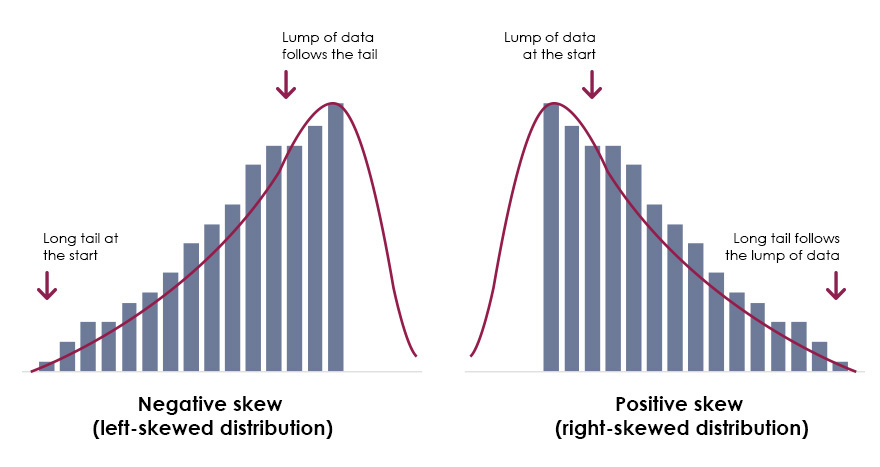

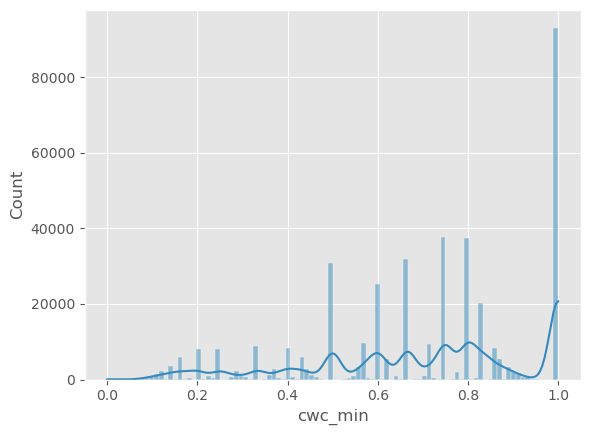

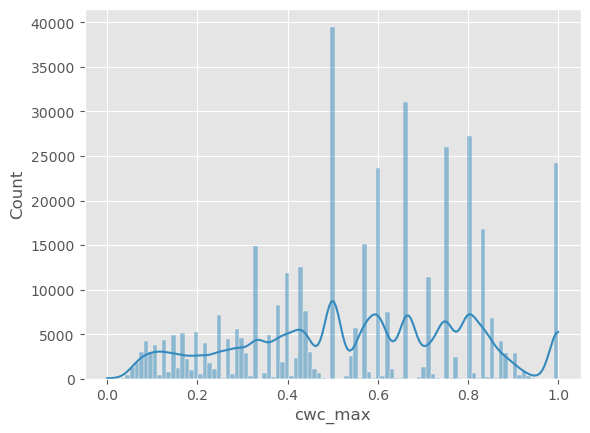

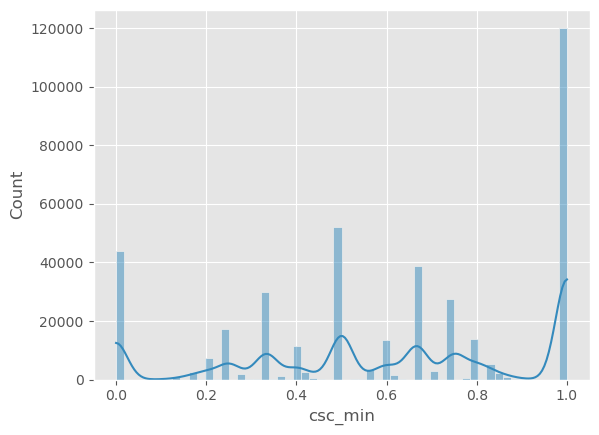

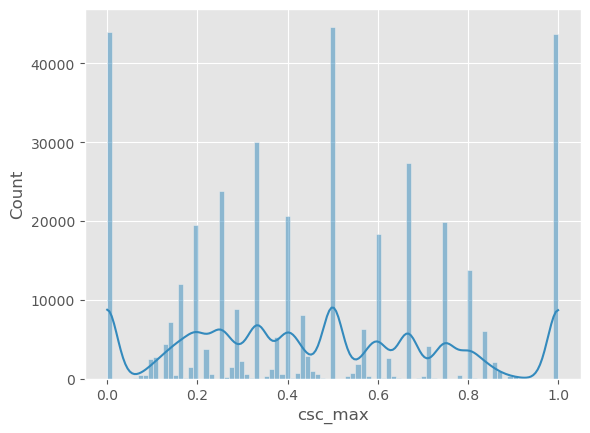

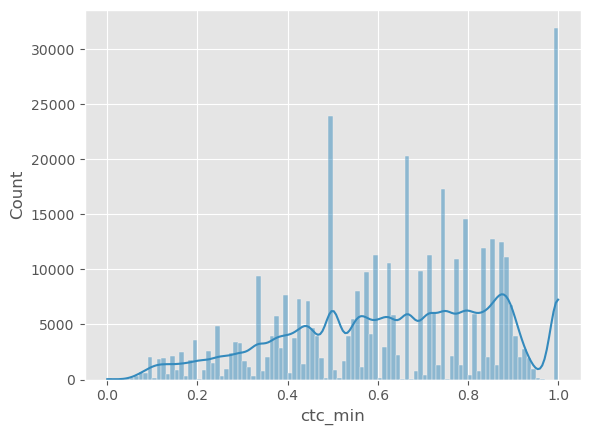

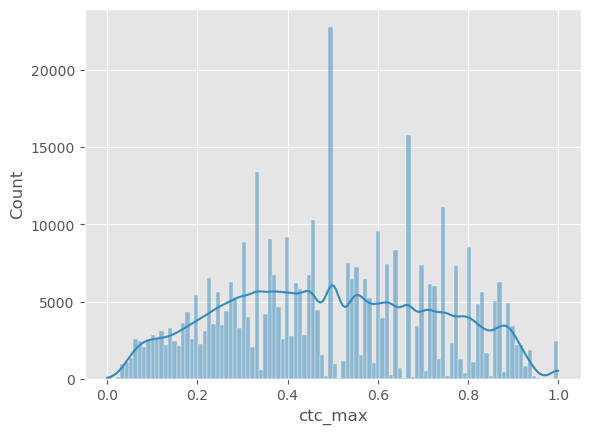

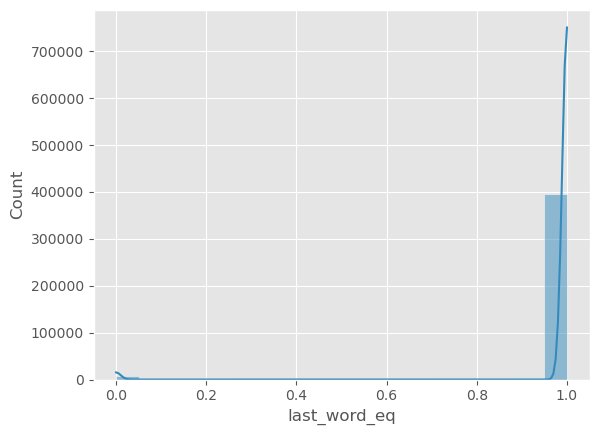

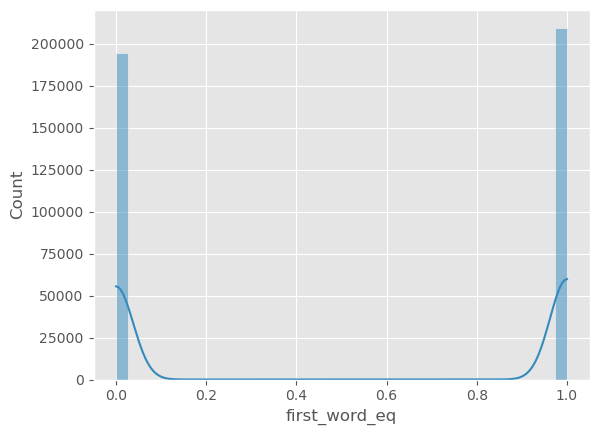

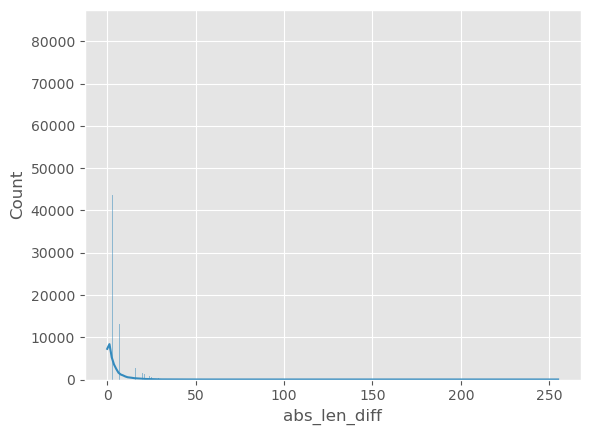

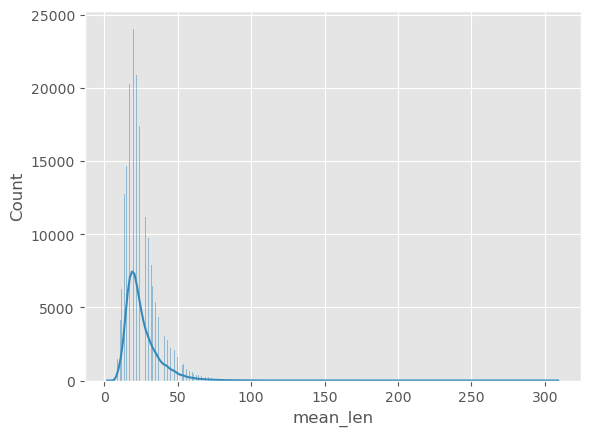

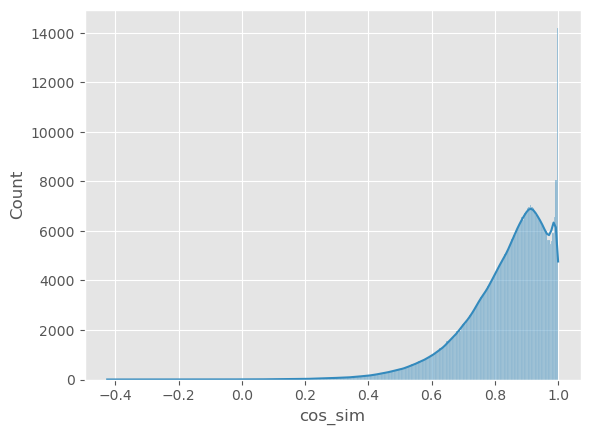

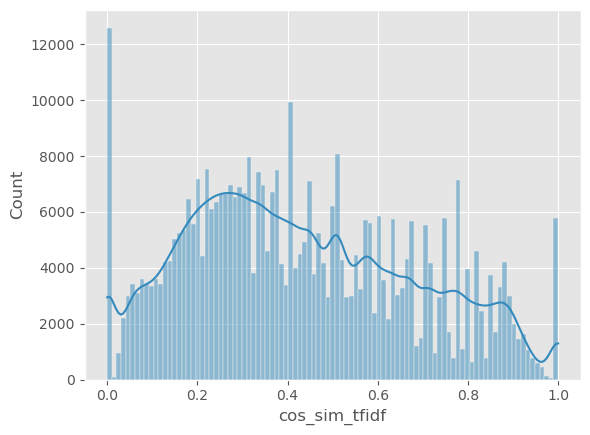

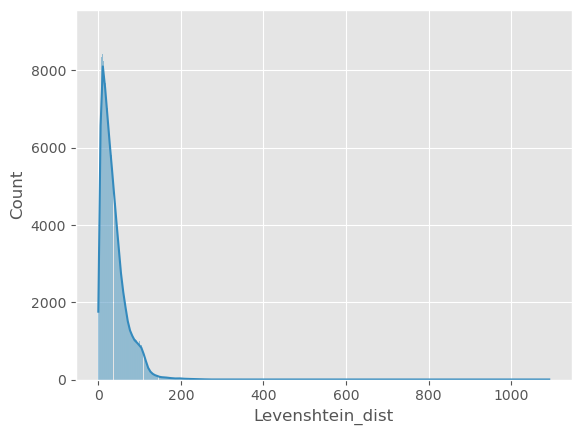

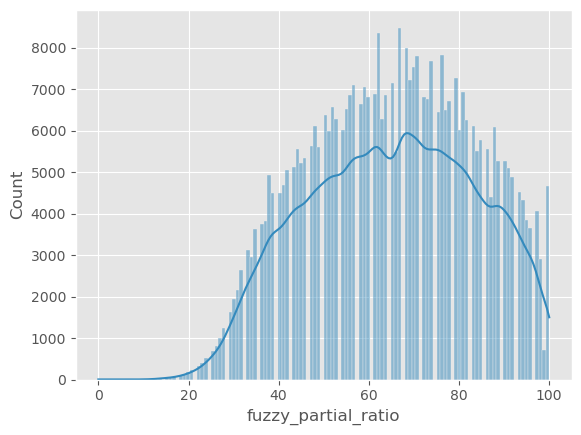

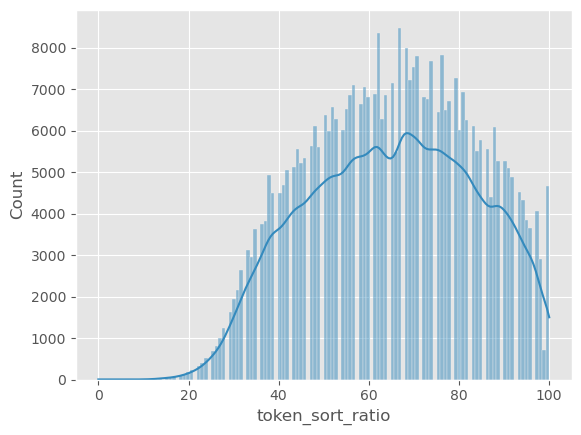

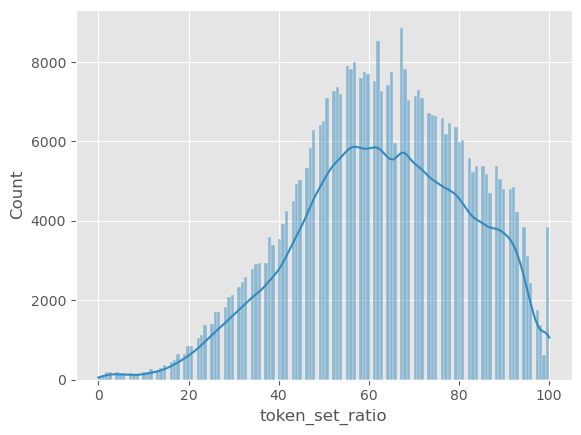

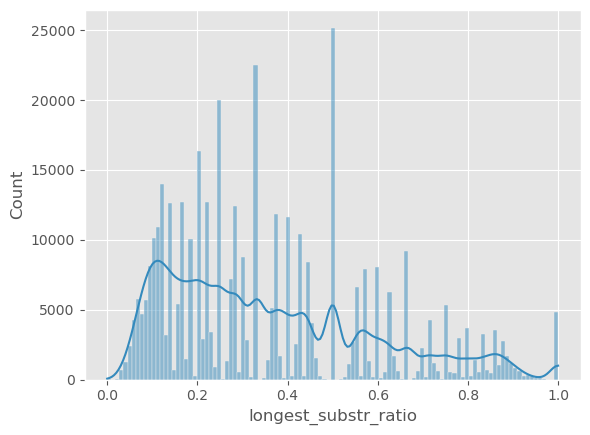

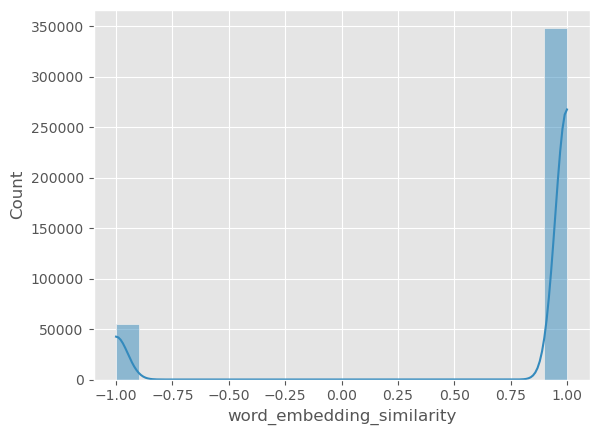

In [33]:
for feature in features:
    sns.histplot(data= train, x= feature, kde= True)
    plt.show()

**Highlights:**
    
    1. last_word_eq, first_word_eq, and word_embedding (?) are binary values
    2. mean_len and lavenshtein_dist are right skewed
    3. cos_sim is left skewed

#### Log-transformation for right-skewed data

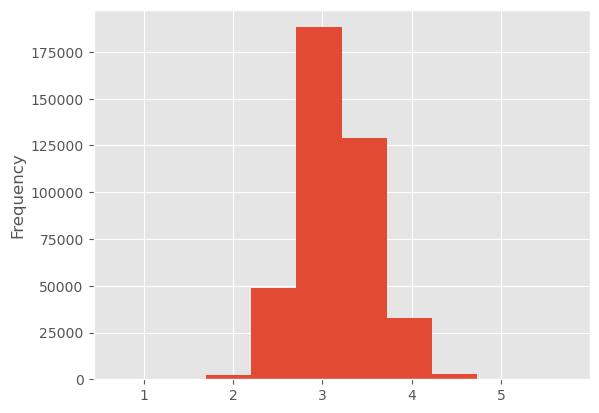

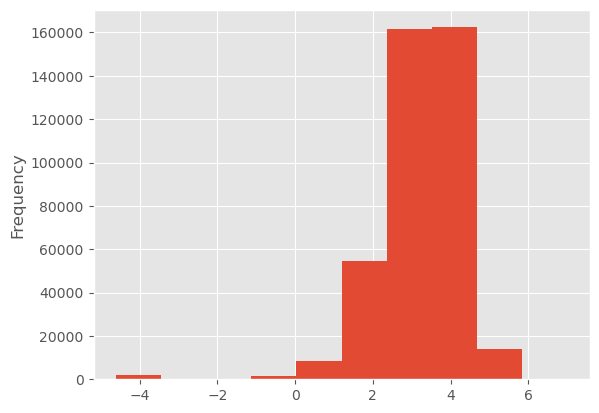

In [88]:
train['mean_len_log']= np.log(train.mean_len)
train['mean_len_log'].plot(kind= 'hist')
plt.show()
# Much better!

pseudo_count = 0.01
train['Levenshtein_dist_log']= np.log(train.Levenshtein_dist+pseudo_count)
train['Levenshtein_dist_log'].plot(kind= 'hist')
plt.show()
# Much better

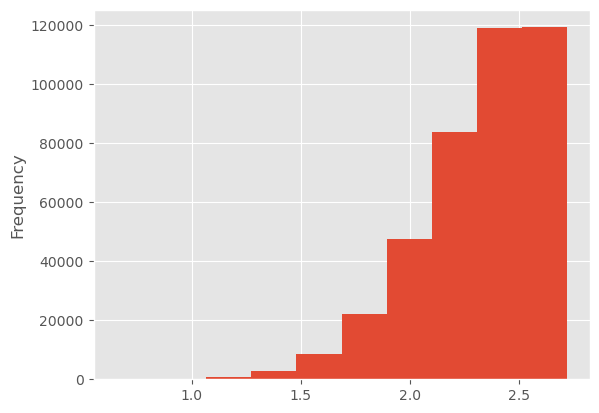

In [78]:
train['cos_sim_exp']= np.exp(train.cos_sim)
train['cos_sim_exp'].plot(kind= 'hist')
plt.show()
# Not that helpful
train.drop('cos_sim_exp', axis=1, inplace=True)

In [90]:
# New features
features=['cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len_log', 'cos_sim', 'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio', 'word_embedding_similarity']

#### <span style="color:blue">2) SHAPRIO

In [91]:
from scipy.stats import shapiro

for feature in features:
    if shapiro(train.mean_len_log).pvalue<=0.05:
        print(f"{feature} is not normally distributed")
    else:
        print(f"{feature} is normally distributed")

cwc_min is not normally distributed
cwc_max is not normally distributed
csc_min is not normally distributed
csc_max is not normally distributed
ctc_min is not normally distributed
ctc_max is not normally distributed
last_word_eq is not normally distributed
first_word_eq is not normally distributed
abs_len_diff is not normally distributed
mean_len_log is not normally distributed
cos_sim is not normally distributed
cos_sim_tfidf is not normally distributed
Levenshtein_dist is not normally distributed
fuzzy_partial_ratio is not normally distributed
token_sort_ratio is not normally distributed
token_set_ratio is not normally distributed
longest_substr_ratio is not normally distributed
word_embedding_similarity is not normally distributed


**Based on the Shaprio test none of the variables is normally distributed**

### 2.1.2 Data Normalization

**Normalization does not change the distribution**

In [ ]:
train.set_index('id', inplace=True)

In [93]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()

X= train[features]
y= train['is_duplicate']

# X_n: normalized X
X_n= scaler.fit_transform(X)
# The output is a numpy array

X_n= pd.DataFrame(X_n, columns= X.columns)
display(X_n.head())

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len_log,cos_sim,cos_sim_tfidf,Levenshtein_dist,fuzzy_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio,word_embedding_similarity
0,0.999986,0.857134,0.999988,0.999988,0.923074,0.799998,1.0,1.0,0.007843,0.523602,0.986370,0.920307,0.008242,0.98,0.98,0.93,0.923072,1.0
1,0.888882,0.571426,0.749985,0.599991,0.733331,0.549999,1.0,1.0,0.019608,0.567875,0.870187,0.424251,0.039377,0.78,0.78,0.62,0.599998,1.0
2,0.666658,0.499995,0.399994,0.285711,0.545452,0.399999,1.0,1.0,0.015686,0.508899,0.805383,0.298760,0.036630,0.46,0.46,0.63,0.090909,1.0
3,0.199997,0.076922,0.249995,0.166665,0.153846,0.105263,1.0,0.0,0.023529,0.550096,0.595084,0.040349,0.048535,0.26,0.26,0.25,0.083333,0.0
4,0.499993,0.249999,0.999955,0.666647,0.624994,0.312499,1.0,1.0,0.031373,0.493018,0.868570,0.272060,0.050366,0.55,0.55,0.47,0.124999,1.0


### 2.1.3 Feature Selection

    2.1) Correlation Matrix

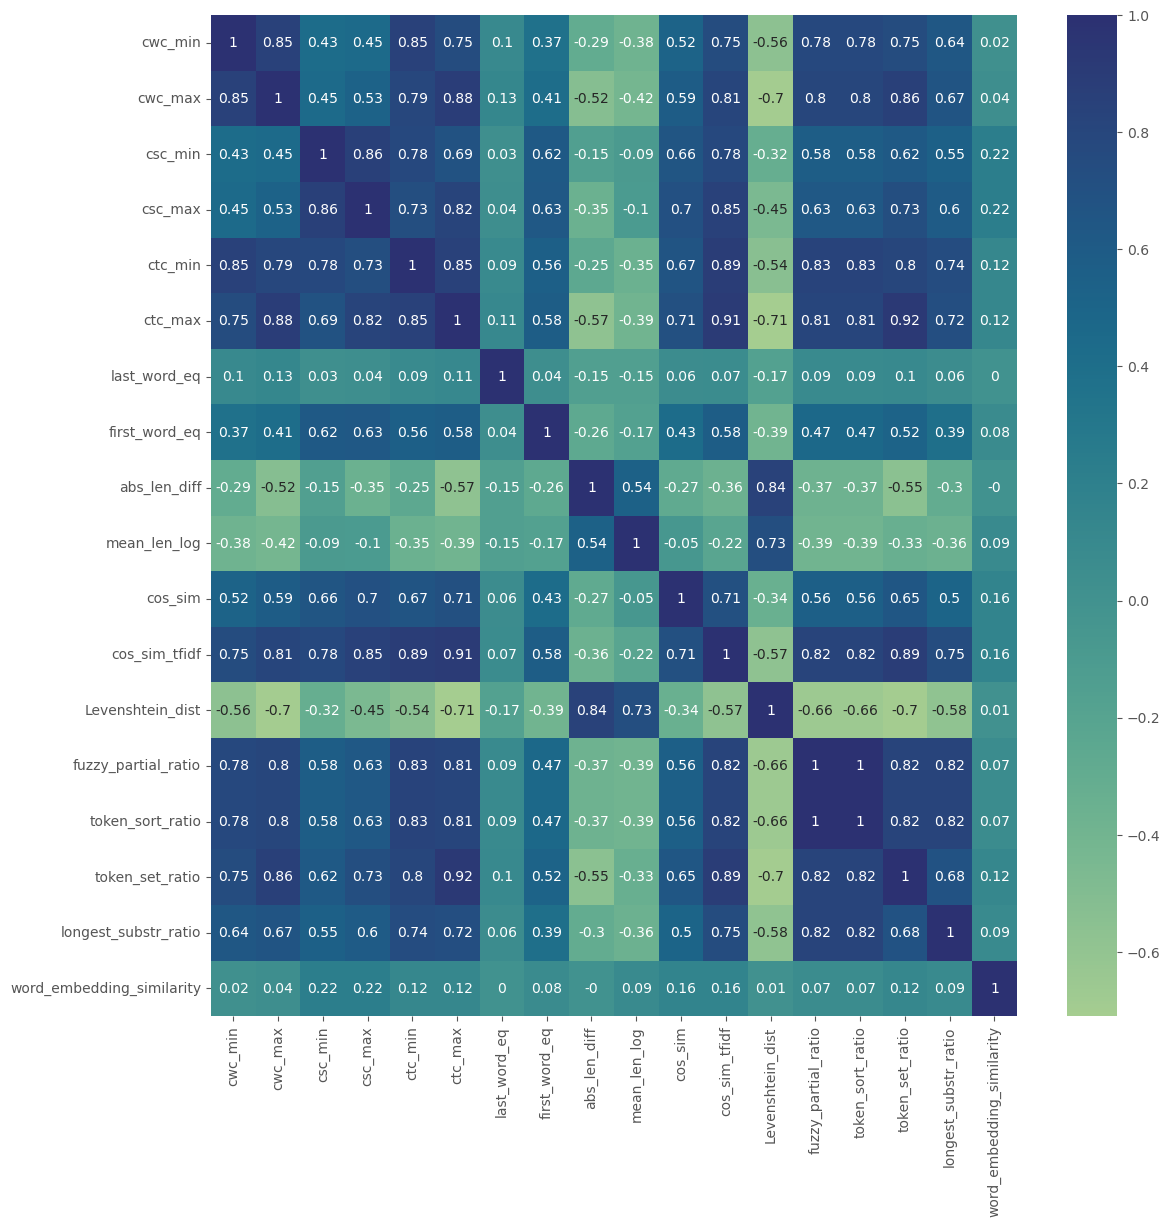

In [98]:
cor_matrix=X_n.corr().round(2)
plt.figure(figsize=(13,13))
sns.heatmap(cor_matrix, annot=True, cmap='crest')
plt.show()

In [133]:
from itertools import combinations

for element in combinations(features,2):
    feature1, feature2= element
    if cor_matrix.loc[feature1, feature2]>0.75:
        print(f"{element[0]} is highly correlated with {element[1]}")

cwc_min is highly correlated with cwc_max
cwc_min is highly correlated with ctc_min
cwc_min is highly correlated with fuzzy_partial_ratio
cwc_min is highly correlated with token_sort_ratio
cwc_max is highly correlated with ctc_min
cwc_max is highly correlated with ctc_max
cwc_max is highly correlated with cos_sim_tfidf
cwc_max is highly correlated with fuzzy_partial_ratio
cwc_max is highly correlated with token_sort_ratio
cwc_max is highly correlated with token_set_ratio
csc_min is highly correlated with csc_max
csc_min is highly correlated with ctc_min
csc_min is highly correlated with cos_sim_tfidf
csc_max is highly correlated with ctc_max
csc_max is highly correlated with cos_sim_tfidf
ctc_min is highly correlated with ctc_max
ctc_min is highly correlated with cos_sim_tfidf
ctc_min is highly correlated with fuzzy_partial_ratio
ctc_min is highly correlated with token_sort_ratio
ctc_min is highly correlated with token_set_ratio
ctc_max is highly correlated with cos_sim_tfidf
ctc_max i

**Almost all the feature selection techniques are prone to highly correlated features. Therefore, we have to take of the highly correlated features here and keep the ones that make more sense for our analysis**

1. Keep cos_sim_tfidf and remove fuzzy_partial_ratio
2. Keep cos_sim
3. Keep mean_len_log
4. Keep last_word_eq
5. Keep first_word_eq
6. Keep longest_substr_ratio and remove fuzzy_partial_ratio
7. Keep token_sort_ratio and remove token_set_ratio, cwc_min, cwc_max, ctc_min, and ctc_max 
8. Keep word_embedding_similarity
9. Keep Levenshtein_dist and remove abs_len_diff

THE NEW LIST OF FEATURES ARE: ['cos_sim_tfidf', 'cos_sim', 'mean_len_log', 'last_word_eq', 'first_word_eq', 'longest_substr_ratio', 'token_sort_ratio', 'word_embedding_similarity', 'Levenshtein_dist']

In [148]:
features= ['cos_sim_tfidf', 'cos_sim', 'mean_len_log', 'last_word_eq', 'first_word_eq', 'longest_substr_ratio', 'token_sort_ratio', 'word_embedding_similarity', 'Levenshtein_dist']
X_n= X_n.loc[:,['cos_sim_tfidf', 'cos_sim', 'mean_len_log', 'last_word_eq', 'first_word_eq', 'longest_substr_ratio', 'token_sort_ratio', 'word_embedding_similarity', 'Levenshtein_dist']]

    2.1) Remove features with low variance
    
consideration: VarianceThreshold treats features independently.
Recommendation: If there are dependencies or interactions between features that are important for your model, VarianceThreshold might not be the most suitable method.

In [149]:
from sklearn.feature_selection import VarianceThreshold
vt= VarianceThreshold(threshold= 0.001)
selected_features= vt.fit_transform(X_n, y)

print(vt.get_feature_names_out(), '\n')

print(f"The values that have variance close to 0: {set.difference(set(features), set(vt.get_feature_names_out()))}")

# getfield These are the columns with variance close to zero!

['cos_sim_tfidf' 'cos_sim' 'mean_len_log' 'last_word_eq' 'first_word_eq'
 'longest_substr_ratio' 'token_sort_ratio' 'word_embedding_similarity'] 

The values that have variance close to 0: {'Levenshtein_dist'}


In [14]:
X_n.drop('abs_len_diff', axis=1, inplace=True)

    2.3) Chi-Squared
    
The Chi-Squared (χ²) test for feature selection is commonly used when dealing with categorical data. This statistical test helps assess the independence between categorical variables. When applying the Chi-Squared test for feature selection, several assumptions and considerations should be kept in mind:

Categorical Data:

Assumption: The data should consist of categorical variables.
Rationale: The Chi-Squared test is designed for categorical data, particularly when analyzing associations between two categorical variables.
Independence:

Assumption: The observations are assumed to be independent.
Rationale: The test evaluates whether observed frequencies differ significantly from expected frequencies under the assumption of independence. Independence is a key assumption for the validity of the Chi-Squared test.
Expected Cell Frequencies:

Consideration: The expected cell frequencies should be reasonably large.
Rationale: For the Chi-Squared test to provide reliable results, the expected frequencies in each cell of the contingency table should not be too small. Low expected frequencies may lead to inaccurate p-values.
Sample Size:

Consideration: The test is sensitive to sample size.
Rationale: With large sample sizes, small deviations from expected frequencies may become statistically significant. It's important to consider both the statistical significance and the practical significance of the results.
Categories in Each Variable:

Consideration: Each variable should have multiple categories.
Rationale: The Chi-Squared test is most informative when variables have more than two categories. For binary variables, other methods like point-biserial correlation or mutual information might be more appropriate.
No Empty Cells:

Consideration: The contingency table should not have empty cells.
Rationale: Empty cells lead to undefined or infinite expected frequencies, making the Chi-Squared test inappropriate.

**THIS IS NOT THE BECT TEST FOR OUR CASE**

In [141]:
# from sklearn.feature_selection import chi2, SelectKBest

# chi_kbest= SelectKBest(score_func=chi2, k=10)
# kbest= chi_kbest.fit_transform(X=X_n, y=y)
# print(kbest)
# chi_kbest.get_feature_names_out()

    2.4) Recrusive Feature Elimination
    
    Linear Assumption:

Assumption: RFE often assumes a linear relationship between features and the response variable. If the relationship is nonlinear, RFE might not capture it well.

    Multicollinearity Issues:

Limitation: RFE may struggle with multicollinearity (high correlation between features). If features are highly correlated, RFE may not select the most informative subset and might eliminate features arbitrarily.

In [150]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Feature selection
model= LogisticRegression()
rfe= RFECV(estimator= model, min_features_to_select= 5, cv=5)
rfe.fit(X_n, y)

print(f"The selected features are: {rfe.get_feature_names_out()}")
print(f"Features ranking: {rfe.ranking_}", '\n')

print(set.difference(set(features), set(rfe.get_feature_names_out())))

The selected features are: ['cos_sim' 'mean_len_log' 'longest_substr_ratio' 'token_sort_ratio'
 'word_embedding_similarity' 'Levenshtein_dist']
Features ranking: [2 1 1 3 4 1 1 1 1] 

{'last_word_eq', 'first_word_eq', 'cos_sim_tfidf'}


These three are not important

    2.5) Lasso Regression
    
    Multiple Correlated Features:

Limitation: Lasso may arbitrarily choose one among a group of correlated features and drive the coefficients of the others to zero. This can make it less effective when dealing with highly correlated predictors.

    Assumption of Linearity:

Assumption: Like linear regression, Lasso assumes a linear relationship between the features and the response variable. If the true relationship is highly nonlinear, other modeling techniques may be more appropriate.

In [151]:
from sklearn.linear_model import LassoCV
lasso= LassoCV(cv=5)
lasso.fit(X_n, y)

print(pd.Series(abs(lasso.coef_), index=lasso.feature_names_in_).sort_values(ascending=False))

print("\n")
lasso.feature_names_in_[abs(lasso.coef_)<0.009]

# first_word_eq be removed based on the Lasso regression model

Levenshtein_dist             0.938226
token_sort_ratio             0.797165
cos_sim                      0.455916
mean_len_log                 0.335880
longest_substr_ratio         0.276719
cos_sim_tfidf                0.153541
word_embedding_similarity    0.068604
last_word_eq                 0.040330
first_word_eq                0.003369
dtype: float64




array(['first_word_eq'], dtype=object)

    2.6) Random forest feature selection

In [152]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
rf.fit(X_n, y)

RandomForestClassifier()

In [153]:
rf.feature_importances_

array([0.19250447, 0.22479097, 0.10021229, 0.00272043, 0.01680341,
       0.12207293, 0.18253361, 0.01098712, 0.14737476])

In [154]:
pd.Series(abs(rf.feature_importances_), index=rf.feature_names_in_).sort_values(ascending=False)

cos_sim                      0.224791
cos_sim_tfidf                0.192504
token_sort_ratio             0.182534
Levenshtein_dist             0.147375
longest_substr_ratio         0.122073
mean_len_log                 0.100212
first_word_eq                0.016803
word_embedding_similarity    0.010987
last_word_eq                 0.002720
dtype: float64

#### Conclusion

Based on all the above anlyses, we can remove last_word_eq

In [155]:
X_select= X_n.drop('last_word_eq', axis=1)

### 2.1.4 Visualize the features in two dimensions: TSNE

In [156]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
tsne_results= tsne.fit_transform(X_select)

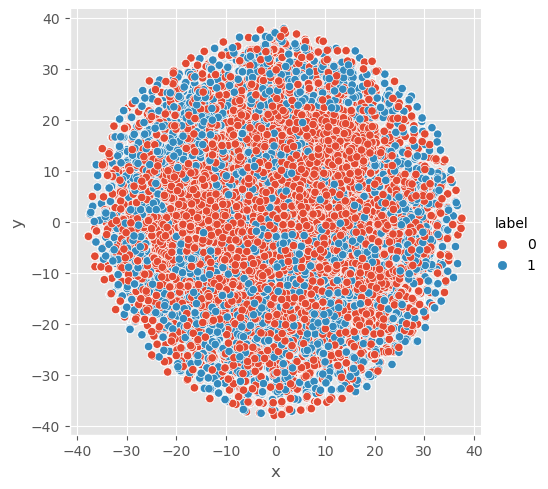

In [157]:
tsne_df= pd.DataFrame({'x': tsne_results[:,0], 'y': tsne_results[:,1], 'label': y})
sns.relplot(data=tsne_df, x='x', y='y', hue= 'label')

### 2.1.5 The final train and test data

In [158]:
print(X_select.columns)
print(X_select.shape)

print(train.columns)
print(train.shape)

df= X_select.merge(train[['question1', 'question2', 'is_duplicate', 'question1_pp', 'question2_pp']], 
                   right_index=True, left_index=True)
print(df.shape)

print(df.isna().sum())
df.fillna('', inplace=True)

print([idx for idx, row in df.iterrows() if len(row.question1_pp) in [0,1]])
print([idx for idx, row in df.iterrows() if len(row.question2_pp) in [0,1]])

Index(['cos_sim_tfidf', 'cos_sim', 'mean_len_log', 'first_word_eq',
       'longest_substr_ratio', 'token_sort_ratio', 'word_embedding_similarity',
       'Levenshtein_dist'],
      dtype='object')
(404290, 8)
Index(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'freq_qid1_total', 'freq_qid2_total', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+freq_q2', 'freq_q1-freq_q2', 'question1_pp', 'question2_pp',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'cos_sim',
       'cos_sim_tfidf', 'Levenshtein_dist', 'fuzzy_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'longest_substr_ratio',
       'word_embedding_similarity', 'bert_embeddings', 'mean_len_log',
       'Levenshtein_dist_log'],
      dtype='object')
(404290, 41)
(404290, 13)
cos_sim_tfidf                0
cos_sim   

**We first have to remove the rows with 0 and 1 characters in question1_pp and question2_pp**

In [159]:
idx_remove= [idx for idx, row in df.iterrows() if (len(row.question1_pp) in [0,1]) | (len(row.question2_pp) in [0,1])]

In [160]:
print(idx_remove)
print(df.shape)

print(df.drop(idx_remove).shape)

df.drop(idx_remove, inplace=True)

[3306, 13016, 20794, 47056, 96725, 104101, 105780, 108978, 115347, 134403, 141281, 151922, 158778, 189659, 190570, 198913, 199110, 201841, 205947, 208485, 213220, 254161, 273065, 357127, 363362, 402423]
(404290, 13)
(404264, 13)


### 2.1.6 Train-Test Split

In [185]:
X= df.drop('is_duplicate', axis=1)
X=X.iloc[:,:8]
y= df['is_duplicate']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, stratify=y, random_state= 123)

Create the train and test datasets

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import roc_auc_score

### Check if we have an imbalanced problem

In [187]:
df.is_duplicate.value_counts(normalize=True)*100

0    63.07784
1    36.92216
Name: is_duplicate, dtype: float64

It is not extremely imbalanced

## 2.2 Model Development

### 2.2.1 Try a dummy model and find the accuracy

In [188]:
dummy_model= DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)
dummy_predict= dummy_model.predict(X_test)
dummy_predict_proba= dummy_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=dummy_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, dummy_predict_proba)}") 
# Which makes sense

The accuracy of the model is: 0.50311058340445
The AUC score is: 0.5


### 2.2.2 Logistic Regression

In [192]:
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
log_predict= log_model.predict(X_test)
log_predict_proba= log_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}") 

The accuracy of the model is: 0.6573163642660136
The AUC score is: 0.7317611830649923


#### Hyperparameter tuning

In [196]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2']  # Regularization penalty
}

grid_search= GridSearchCV(estimator= log_model, param_grid= param_grid, scoring= 'roc_auc', cv= 10)
grid_search.fit(X_train, y_train)
log_model_best= grid_search.best_estimator_
print(f"The parameters are: {grid_search.best_params_}")
log_predict= log_model_best.predict(X_test)
log_predict_proba= log_model_best.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=log_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, log_predict_proba)}") 

The parameters are: {'C': 0.01, 'penalty': 'l2'}
The accuracy of the model is: 0.6539274980520203
The AUC score is: 0.7322851117534744


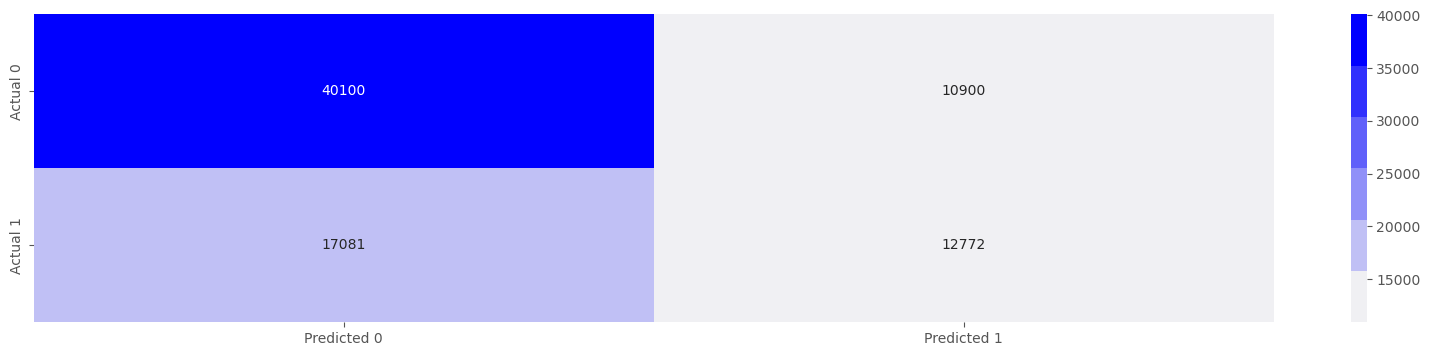

In [206]:
conf_matrix= confusion_matrix(y_test, log_predict)
plt.figure(figsize=(20,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.light_palette("blue"), xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.show()

### 2.2.3 Stockastic Gradient Descent

In [208]:
sgd_model= SGDClassifier(loss= 'hinge')
sgd_model.fit(X_train, y_train)
sgd_predict= sgd_model.predict(X_test)
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=sgd_predict)}')

The accuracy of the model is: 0.6580831880078661


### 2.2.4 Random Forest

In [210]:
rf_model= RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predict= rf_model.predict(X_test)
rf_predict_proba= rf_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

The accuracy of the model is: 0.7248339579236392
The AUC score is: 0.8068787247053043


In [215]:
# Define hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search= GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring= 'roc_auc', cv=10, verbose=1)
grid_search.fit(X_train, y_train)
best_rf= grid_search.best_estimator_
rf_predict= best_rf.predict(X_test)
rf_predict_proba= best_rf.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=rf_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, rf_predict_proba)}") 

Fitting 10 folds for each of 81 candidates, totalling 810 fits
The accuracy of the model is: 0.7295956859980458
The AUC score is: 0.8127177762539712


In [216]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 150}

In [224]:
### 6. XGB
import xgboost as xgb
xgb_model= xgb.XGBClassifier(objective= 'binary:logistic', eval_metric= 'auc')
xgb_model.fit(X_train, y_train)
xgb_predict= xgb_model.predict(X_test)
xgb_predict_proba= xgb_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=xgb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, xgb_predict_proba)}")

The accuracy of the model is: 0.7257244629141776
The AUC score is: 0.8064298451300261


In [225]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search= GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring= 'roc_auc', cv=10, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb= grid_search.best_estimator_
xgb_predict= best_xgb.predict(X_test)
xgb_predict_proba= best_xgb.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=xgb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, xgb_predict_proba)}") 

Fitting 10 folds for each of 27 candidates, totalling 270 fits
The accuracy of the model is: 0.7274436322709114
The AUC score is: 0.8083532081710183


In [227]:
svc_model= SVC(kernel='rbf', random_state=123, probability=True)
svc_model.fit(X_train, y_train)
svc_predict= svc_model.predict(X_test)
svc_predict_proba= svc_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=svc_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, svc_predict_proba)}")

AttributeError: predict_proba is not available when  probability=False

In [228]:
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=svc_predict)}')

The accuracy of the model is: 0.6972777757164237


In [229]:
nb_model= GaussianNB()
nb_model.fit(X_train, y_train)
nb_predict= nb_model.predict(X_test)
nb_predict_proba= nb_model.predict_proba(X_test)[:,1]
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=nb_predict)}')
print(f"The AUC score is: {roc_auc_score(y_test, nb_predict_proba)}")

The accuracy of the model is: 0.6611628511001447
The AUC score is: 0.725285730471467


### PCA

In [234]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline= Pipeline([('pca', PCA(n_components=.95)), ('rf', RandomForestClassifier())]) 
pipeline.fit(X_train, y_train)
y_pred= pipeline.predict(X_test)
print(f'The accuracy of the model is: {accuracy_score(y_true=y_test, y_pred=y_pred)}')

The accuracy of the model is: 0.6874451164458957
